In [1]:
from IPython.display import Image
from IPython.display import display, HTML
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from fboost import outlier_iqr, DataPreparator, FeatureBoosterRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from ffx import FFXRegressor
import tensorflow as tf
from tensorflow import keras

from keras.optimizers import Adam
from keras.layers import Lambda
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, concatenate, Conv2D

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

import warnings
warnings.filterwarnings('ignore')

# Set a seed value
seed_value= 0
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

/home/sandra/deedevelopment.ai/resmol/venv/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/sandra/deedevelopment.ai/resmol/venv/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 

In [2]:
data = pd.read_csv('../data/raw/alldata.csv')
data.columns = ['familia','indice_fam','subposicion_1','subposicion_2','subposicion_3','subposicion_4', 'energia']
mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 1
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

In [3]:
# Instantiate the OneHotEncoder
encoder = OneHotEncoder(sparse=False, categories='auto')

X_train = lista_train.drop(['energia'], axis=1)
X_test = lista_test.drop(['energia'], axis=1)

# Fit the encoder and transform the data for both train and test dataframes
encoded_train = encoder.fit_transform(X_train)
encoded_test = encoder.transform(X_test)

# Now, 'encoded_train' and 'encoded_test' are numpy arrays, we can convert them back to dataframes:
X_train_scaled = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(X_train.columns))
X_test_scaled = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(X_test.columns))


y_test = lista_test['energia']
y_train = lista_train['energia']

In [4]:
"""
#############################################
# 4-LINEAR REGRESSION MODEL WITHFEATURE ENGINEERING #
#############################################
"""

model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
r2_linreg_before = model_lr.score(X_test_scaled, y_test)
rmse_linreg_before = np.sqrt(mean_squared_error(y_test, model_lr.predict(X_test_scaled)))
print('LinearRegression R2 (Before feature engineering): ' + str(round(r2_linreg_before, 4)))
print('LinearRegression RMSE (Before feature engineering): ' + str(round(rmse_linreg_before, 4)))

LinearRegression R2 (Before feature engineering): 0.3206
LinearRegression RMSE (Before feature engineering): 3.7424


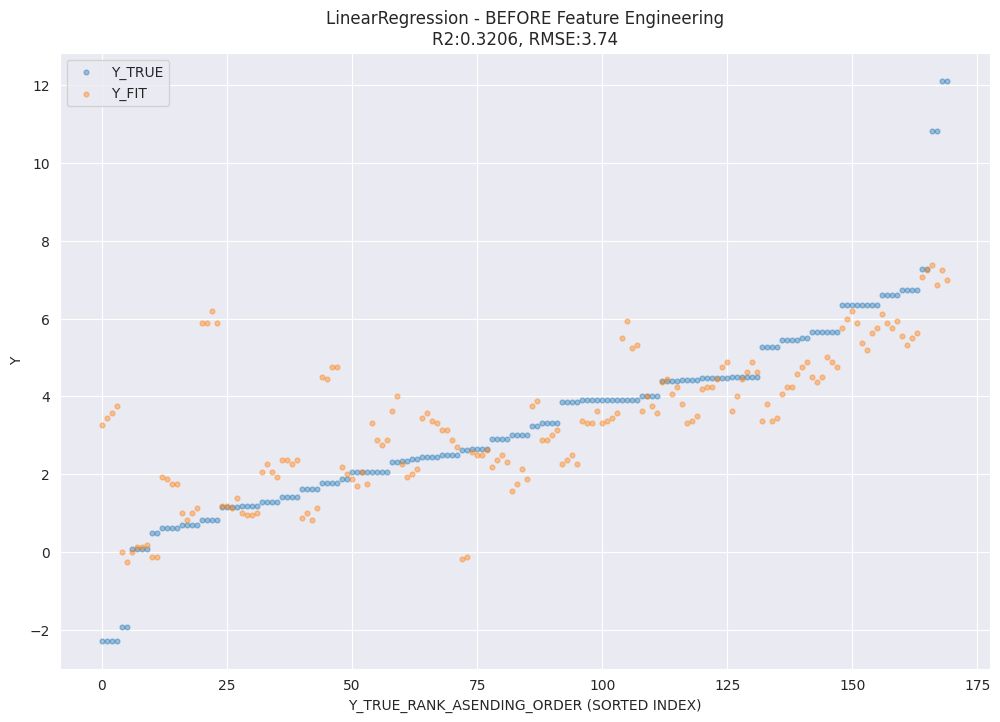

In [5]:
fit_results = pd.DataFrame(y_train.copy())
fit_results.columns = ['Y_TRUE']
test_pred_results = pd.DataFrame(y_test.copy())
test_pred_results.columns = ['Y_TRUE']

fit_results['Y_FIT'] = model_lr.predict(X_train_scaled).ravel()
test_pred_results['Y_PRED'] = model_lr.predict(X_test_scaled)

fit_results = fit_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)
test_pred_results = test_pred_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)

#### SCATTER PLOT
plt.figure(figsize=(12,8))
plt.scatter(fit_results.index,  fit_results['Y_TRUE'], alpha = 0.4, s = 12, label = 'Y_TRUE')
plt.scatter(fit_results.index,  fit_results['Y_FIT'], alpha = 0.4, s = 12, label = 'Y_FIT')
plt.xlabel('Y_TRUE_RANK_ASENDING_ORDER (SORTED INDEX)')
plt.ylabel('Y')
plt.title('LinearRegression - BEFORE Feature Engineering' + '\n' + 'R2:' + str(round(r2_linreg_before, 4)) + ', RMSE:' + str(round(rmse_linreg_before, 2)))
plt.legend()

In [6]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        print(
            "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
        )

    def on_test_batch_end(self, batch, logs=None):
        print(
            "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
        )

    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and mean absolute error is {:7.2f}.".format(
                epoch, logs["loss"], logs["mae"]
            )
        )

In [7]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=50):
        super().__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [8]:
# Reload the dataset
data = pd.read_csv('../data/raw/alldata.csv')
data.columns = ['familia','indice_fam','subposicion_1','subposicion_2','subposicion_3','subposicion_4', 'energia']
mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 1
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

X_train = lista_train.drop(['energia'], axis=1)
X_test = lista_test.drop(['energia'], axis=1)

y_test = lista_test['energia']
y_train = lista_train['energia']


In [9]:

# assuming df is your DataFrame
df = lista_train.drop(['energia'], axis=1)

# replace zeros with np.nan
df = df.replace(0, np.nan)

# instantiate OneHotEncoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

# apply OneHotEncoder to df
onehot_df = enc.fit_transform(df)

# create H matrix
H = np.zeros(df.shape)

# specify the position of non-zero values in H
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if not np.isnan(df.iloc[i, j]):
            H[i, j] = j+1  # or just 1, based on your requirements



In [10]:

X_train_array = np.concatenate((onehot_df, H), axis=1)
X_train_encoded = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))

input_shape_train = (X_train_encoded.shape[1],1)
# assuming onehot_df_encoded and H are your input data and are numpy arrays
# reshape data for Conv1D, the format should be (n_samples, steps, channels)
onehot_df_encoded = onehot_df.reshape((170, 24, 1))
H_encoded = H.reshape((170, 4, 1))

# target data
y_train = np.array(y_train)
input_shape_train

(28, 1)

In [11]:
# assuming df is your DataFrame
df_test = lista_test.drop(['energia'], axis=1)

# replace zeros with np.nan
df_test = df_test.replace(0, np.nan)

# instantiate OneHotEncoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

# apply OneHotEncoder to df
onehot_df_test = enc.fit_transform(df_test)

# create H matrix
H_test = np.zeros(df_test.shape)

# specify the position of non-zero values in H
for i in range(df_test.shape[0]):
    for j in range(df_test.shape[1]):
        if not np.isnan(df_test.iloc[i, j]):
            H_test[i, j] = j+1  # or just 1, based on your requirements


In [12]:
onehot_df_test_encoded = onehot_df_test.reshape((onehot_df_test.shape[0], 24, 1))
H_test_encoded = H_test.reshape((H_test.shape[0], 4, 1))

X_test_array = np.concatenate((onehot_df_test, H_test), axis=1)
X_test_encoded = X_test_array.reshape((X_test_array.shape[0], X_test_array.shape[1], 1))
input_shape_test = (X_test_encoded.shape[1],1)
# target data
y_test = np.array(y_test)
y_test.shape

(1125,)

In [16]:


def build_model(hp):
    # Input layers
    input_onehot_1d = Input(shape=(28,1))


    # Convolutional layers
    conv_onehot_1d = Conv1D(filters=hp.Int('conv_filters_onehot', min_value=16, max_value=128, step=16),
                            kernel_size=hp.Choice('conv_kernel_size_onehot', values=[2,3,5]),
                            activation='relu')(input_onehot_1d)



    # Pooling layers
    pool_onehot_1d = MaxPooling1D(pool_size=2)(conv_onehot_1d)

    # Flatten layers
    flat_onehot_1d = Flatten()(pool_onehot_1d)

    # Dense layers
    dense_1d = Dense(units=hp.Int('dense_units_1', min_value=128, max_value=512, step=64),
                     activation='relu')(flat_onehot_1d)
    dense_2_1d = Dense(units=hp.Int('dense_units_2', min_value=64, max_value=256, step=64),
                       activation='relu')(dense_1d)
    output_1d = Dense(1, activation='linear')(dense_2_1d)  # assuming this is a regression problem

    # create model with two inputs
    model_1d = Model(inputs=[input_onehot_1d], outputs=output_1d)

    # compile model
    opt_1d = Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='LOG', default=0.001))
    model_1d.compile(optimizer=opt_1d, loss='logcosh', metrics=['mae'])

    return model_1d

tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=15,  # Number of different combinations to try
    executions_per_trial=20,  # Number of trials to run each combination, the results will be averaged
    overwrite=True,
    directory="keras_tuner",
    project_name='resmol')

tuner.search_space_summary()

Search space summary
Default search space size: 5
conv_filters_onehot (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv_kernel_size_onehot (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 5], 'ordered': True}
dense_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
dense_units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [17]:
from sklearn.model_selection import train_test_split

# Split the data
onehot_df_train, onehot_df_val, y_train, y_val = train_test_split(X_train_encoded, y_train, test_size=0.2, random_state=42)

# Continue with the tuner search
tuner.search([onehot_df_train], y_train, epochs=30, validation_data=([onehot_df_val], y_val))



Trial 15 Complete [00h 00m 50s]
val_mae: 1.0583832621574403

Best val_mae So Far: 0.8896769344806671
Total elapsed time: 00h 11m 41s
INFO:tensorflow:Oracle triggered exit


In [20]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
y_train = lista_train['energia']
y_train = np.array(y_train)
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_encoded, y_train, epochs=100, validation_split=0.2, verbose=1)

# Now you can make predictions on your test set
predictions = model.predict(X_test_encoded)

# If you want to compare with the true values
# Assuming y_test are your true values
errors = predictions - y_test  # This will give the difference between your predictions and the actual values

Epoch 1/100
5/5 [==============================] - 0s 33ms/step - loss: 1.8118 - mae: 2.3964 - val_loss: 2.1621 - val_mae: 2.7303
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 1.2783 - mae: 1.8268 - val_loss: 1.8449 - val_mae: 2.4129
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 0.9521 - mae: 1.4929 - val_loss: 1.6750 - val_mae: 2.2137
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 0.8144 - mae: 1.3545 - val_loss: 1.4433 - val_mae: 1.9172
Epoch 5/100
5/5 [==============================] - 0s 11ms/step - loss: 0.6261 - mae: 1.0995 - val_loss: 1.3363 - val_mae: 1.8276
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 0.5076 - mae: 0.9376 - val_loss: 1.3217 - val_mae: 1.9006
Epoch 7/100
5/5 [==============================] - 0s 11ms/step - loss: 0.4711 - mae: 0.8877 - val_loss: 1.3368 - val_mae: 1.9222
Epoch 8/100
5/5 [==============================] - 0s 11ms/step - loss: 0.4413 - mae: 0.84

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Let's assume y_test are your true values and predictions are the predicted values
y_test = np.array(y_test)  # Ensure y_test is a numpy array for calculation
predictions = np.array(predictions)  # Ensure predictions is a numpy array for calculation

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Compute differences between predicted and real values
differences = predictions.flatten() - y_test.flatten()

print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('Mean Absolute Error (MAE): ', mae)
print('R-squared Score: ', r2)


Mean Squared Error (MSE):  15.087115155330856
Root Mean Squared Error (RMSE):  3.8842135826098514
Mean Absolute Error (MAE):  2.520974678131557
R-squared Score:  0.26812360486793363


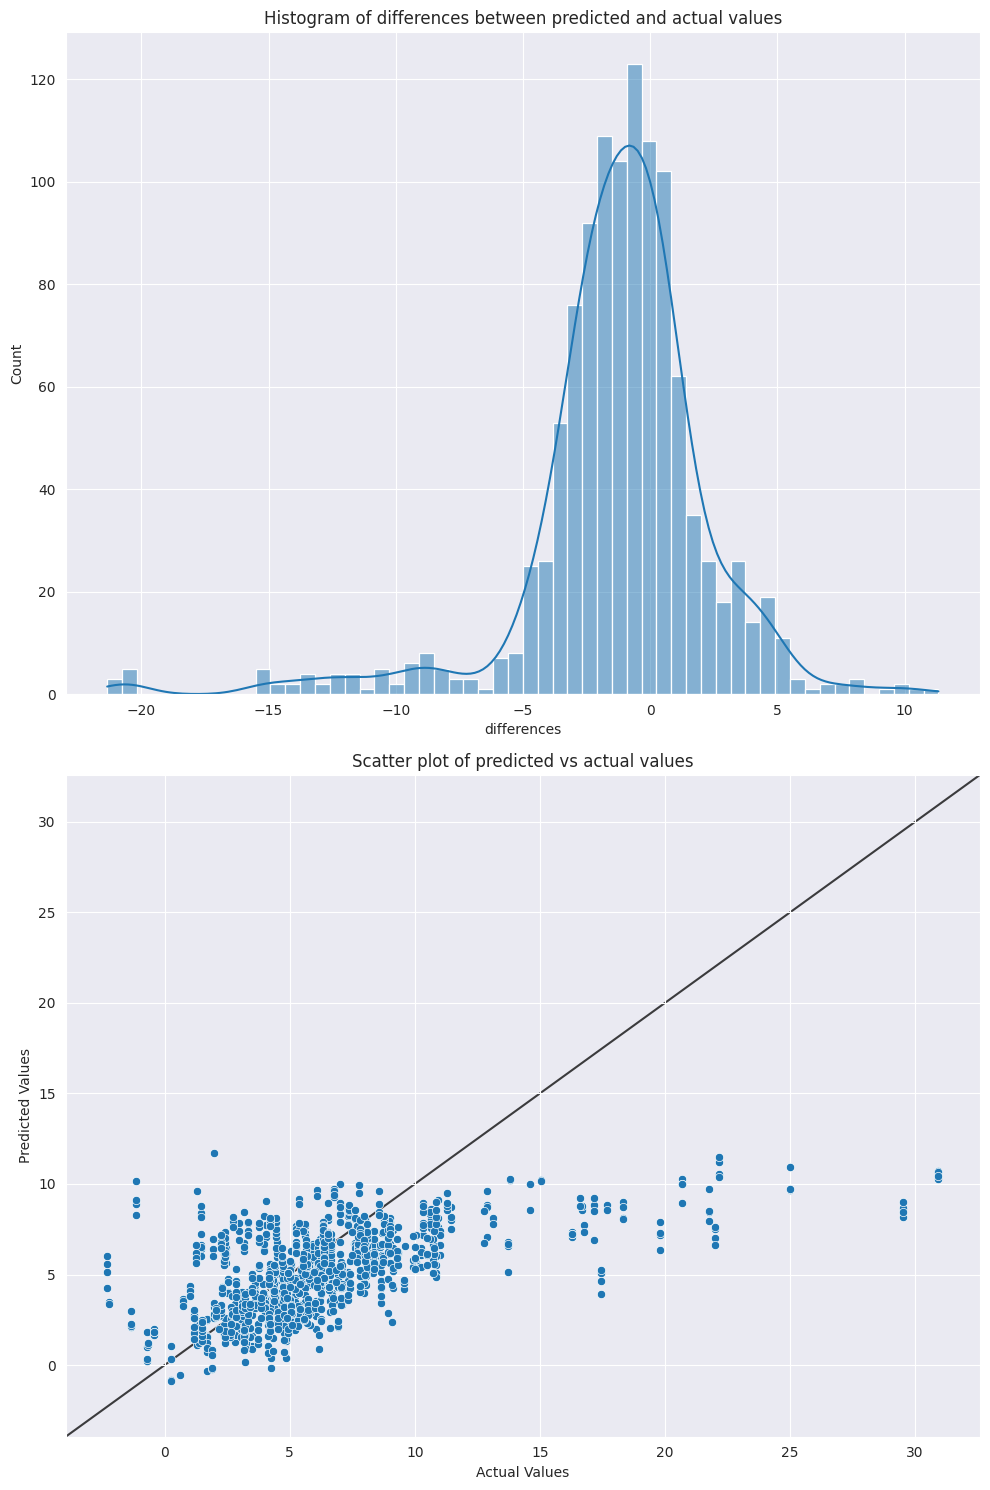

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for the differences for use with seaborn
diff_df = pd.DataFrame(data={'differences': differences})

# Create a figure with two subplots: a histogram of the differences and a scatter plot of predicted vs real values
fig, axs = plt.subplots(nrows=2, figsize=(10, 15))

# Plot histogram
sns.histplot(data=diff_df, x="differences", kde=True, ax=axs[0])
axs[0].set_title('Histogram of differences between predicted and actual values')

# Plot scatter
y_pred = np.squeeze(predictions)
sns.scatterplot(x=y_test, y=y_pred, ax=axs[1])
axs[1].set_title('Scatter plot of predicted vs actual values')
axs[1].set_xlabel('Actual Values')
axs[1].set_ylabel('Predicted Values')

# Draw a diagonal line on the scatterplot
lims = [np.min([axs[1].get_xlim(), axs[1].get_ylim()]),  # min of both axes
        np.max([axs[1].get_xlim(), axs[1].get_ylim()])]  # max of both axes
axs[1].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
axs[1].set_xlim(lims)
axs[1].set_ylim(lims)

plt.tight_layout()
plt.show()


(1125, 1)

In [ ]:


# Define inputs
input_onehot = Input(shape=(24, 1, 1))  # onehot_df
input_h = Input(shape=(4, 1, 1))  # H

# Convolutional Layer
conv_layer = Conv2D(128, kernel_size=(1, 1), activation='relu')  # Number of filters = 32. This can be changed based on your preference

# Applying Convolutional layer on both inputs
conv_onehot = conv_layer(input_onehot)
conv_h = conv_layer(input_h)

# Flatten Layers
flatten_onehot = Flatten()(conv_onehot)
flatten_h = Flatten()(conv_h)

# Concatenating the two inputs after Convolutional layer
#concat_layer = concatenate([flatten_onehot, flatten_h])

# Dense Layers
#dense_1 = Dense(256, activation='relu')(concat_layer)
dense_1 = Dense(1024, activation='relu')(flatten_onehot)
#dense_1 = Dropout(0.1)(dense_1)  # 20% dropout
dense_2 = Dense(512, activation='relu')(dense_1)
#dense_2 = Dropout(0.1)(dense_2)  # 20% dropout
dense_3 = Dense(256, activation='relu')(dense_2)
#dense_3 = Dropout(0.1)(dense_3)  # 20% dropout
dense_4 = Dense(128, activation='relu')(dense_3)
#dense_4 = Dropout(0.1)(dense_4)  # 20% dropout
dense_5 = Dense(64, activation='relu')(dense_4)
#dense_5 = Dropout(0.1)(dense_5)  # 20% dropout
dense_6 = Dense(32, activation='relu')(dense_5)
#dense_6 = Dropout(0.1)(dense_6)  # 20% dropout
dense_7 = Dense(16, activation='relu')(dense_6)
#dense_7 = Dropout(0.1)(dense_7)  # 20% dropout
# Output Layer with a Scaler (min-max scaling)
output = Dense(1, activation='linear')(dense_7)  # Dense layer before scaling

# Define model
model_conv2d = Model(inputs=[input_onehot, input_h], outputs=output)

# Model compilation
opt = Adam(learning_rate=0.001)
model_conv2d.compile(optimizer=opt, loss='logcosh', metrics=['mae'])


In [ ]:

# Train the model
history = model_conv2d.fit([onehot_df_encoded, H_encoded], y_train, epochs=200, batch_size=64, validation_split=0.2, verbose=0,
                           callbacks=[LossAndErrorPrintingCallback(), EarlyStoppingAtMinLoss()])

In [ ]:
# Predict the testing data
y_pred_2d = model_conv2d.predict([onehot_df_test_encoded, H_test_encoded])


In [ ]:
loss_2d = model_conv2d.evaluate([onehot_df_test_encoded, H_test_encoded], y_test)
print('Test loss:', loss_2d)

In [ ]:
# print the first few predicted and real values
for i in range(10):  # print the first 10 values
    print(f"Predicted value: {y_pred_2d[i]}, Real value: {y_test[i]}")

In [ ]:
# plot predicted vs real values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Real')
plt.plot(y_pred_2d, label='Predicted')
plt.legend()
plt.show()


In [ ]:

mse_2d = mean_squared_error(y_test, y_pred_2d)
rmse_2d = sqrt(mse_2d)
mae_2d = mean_absolute_error(y_test, y_pred_2d)
r2_2d = r2_score(y_test, y_pred_2d)

# Print metrics
print(f'Mean Squared Error (MSE): {mse_2d}')
print(f'Root Mean Squared Error (RMSE): {rmse_2d}')
print(f'Mean Absolute Error (MAE): {mae_2d}')
print(f'R^2 Score: {r2_2d}')
